## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [143]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

/Users/ruthwik/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


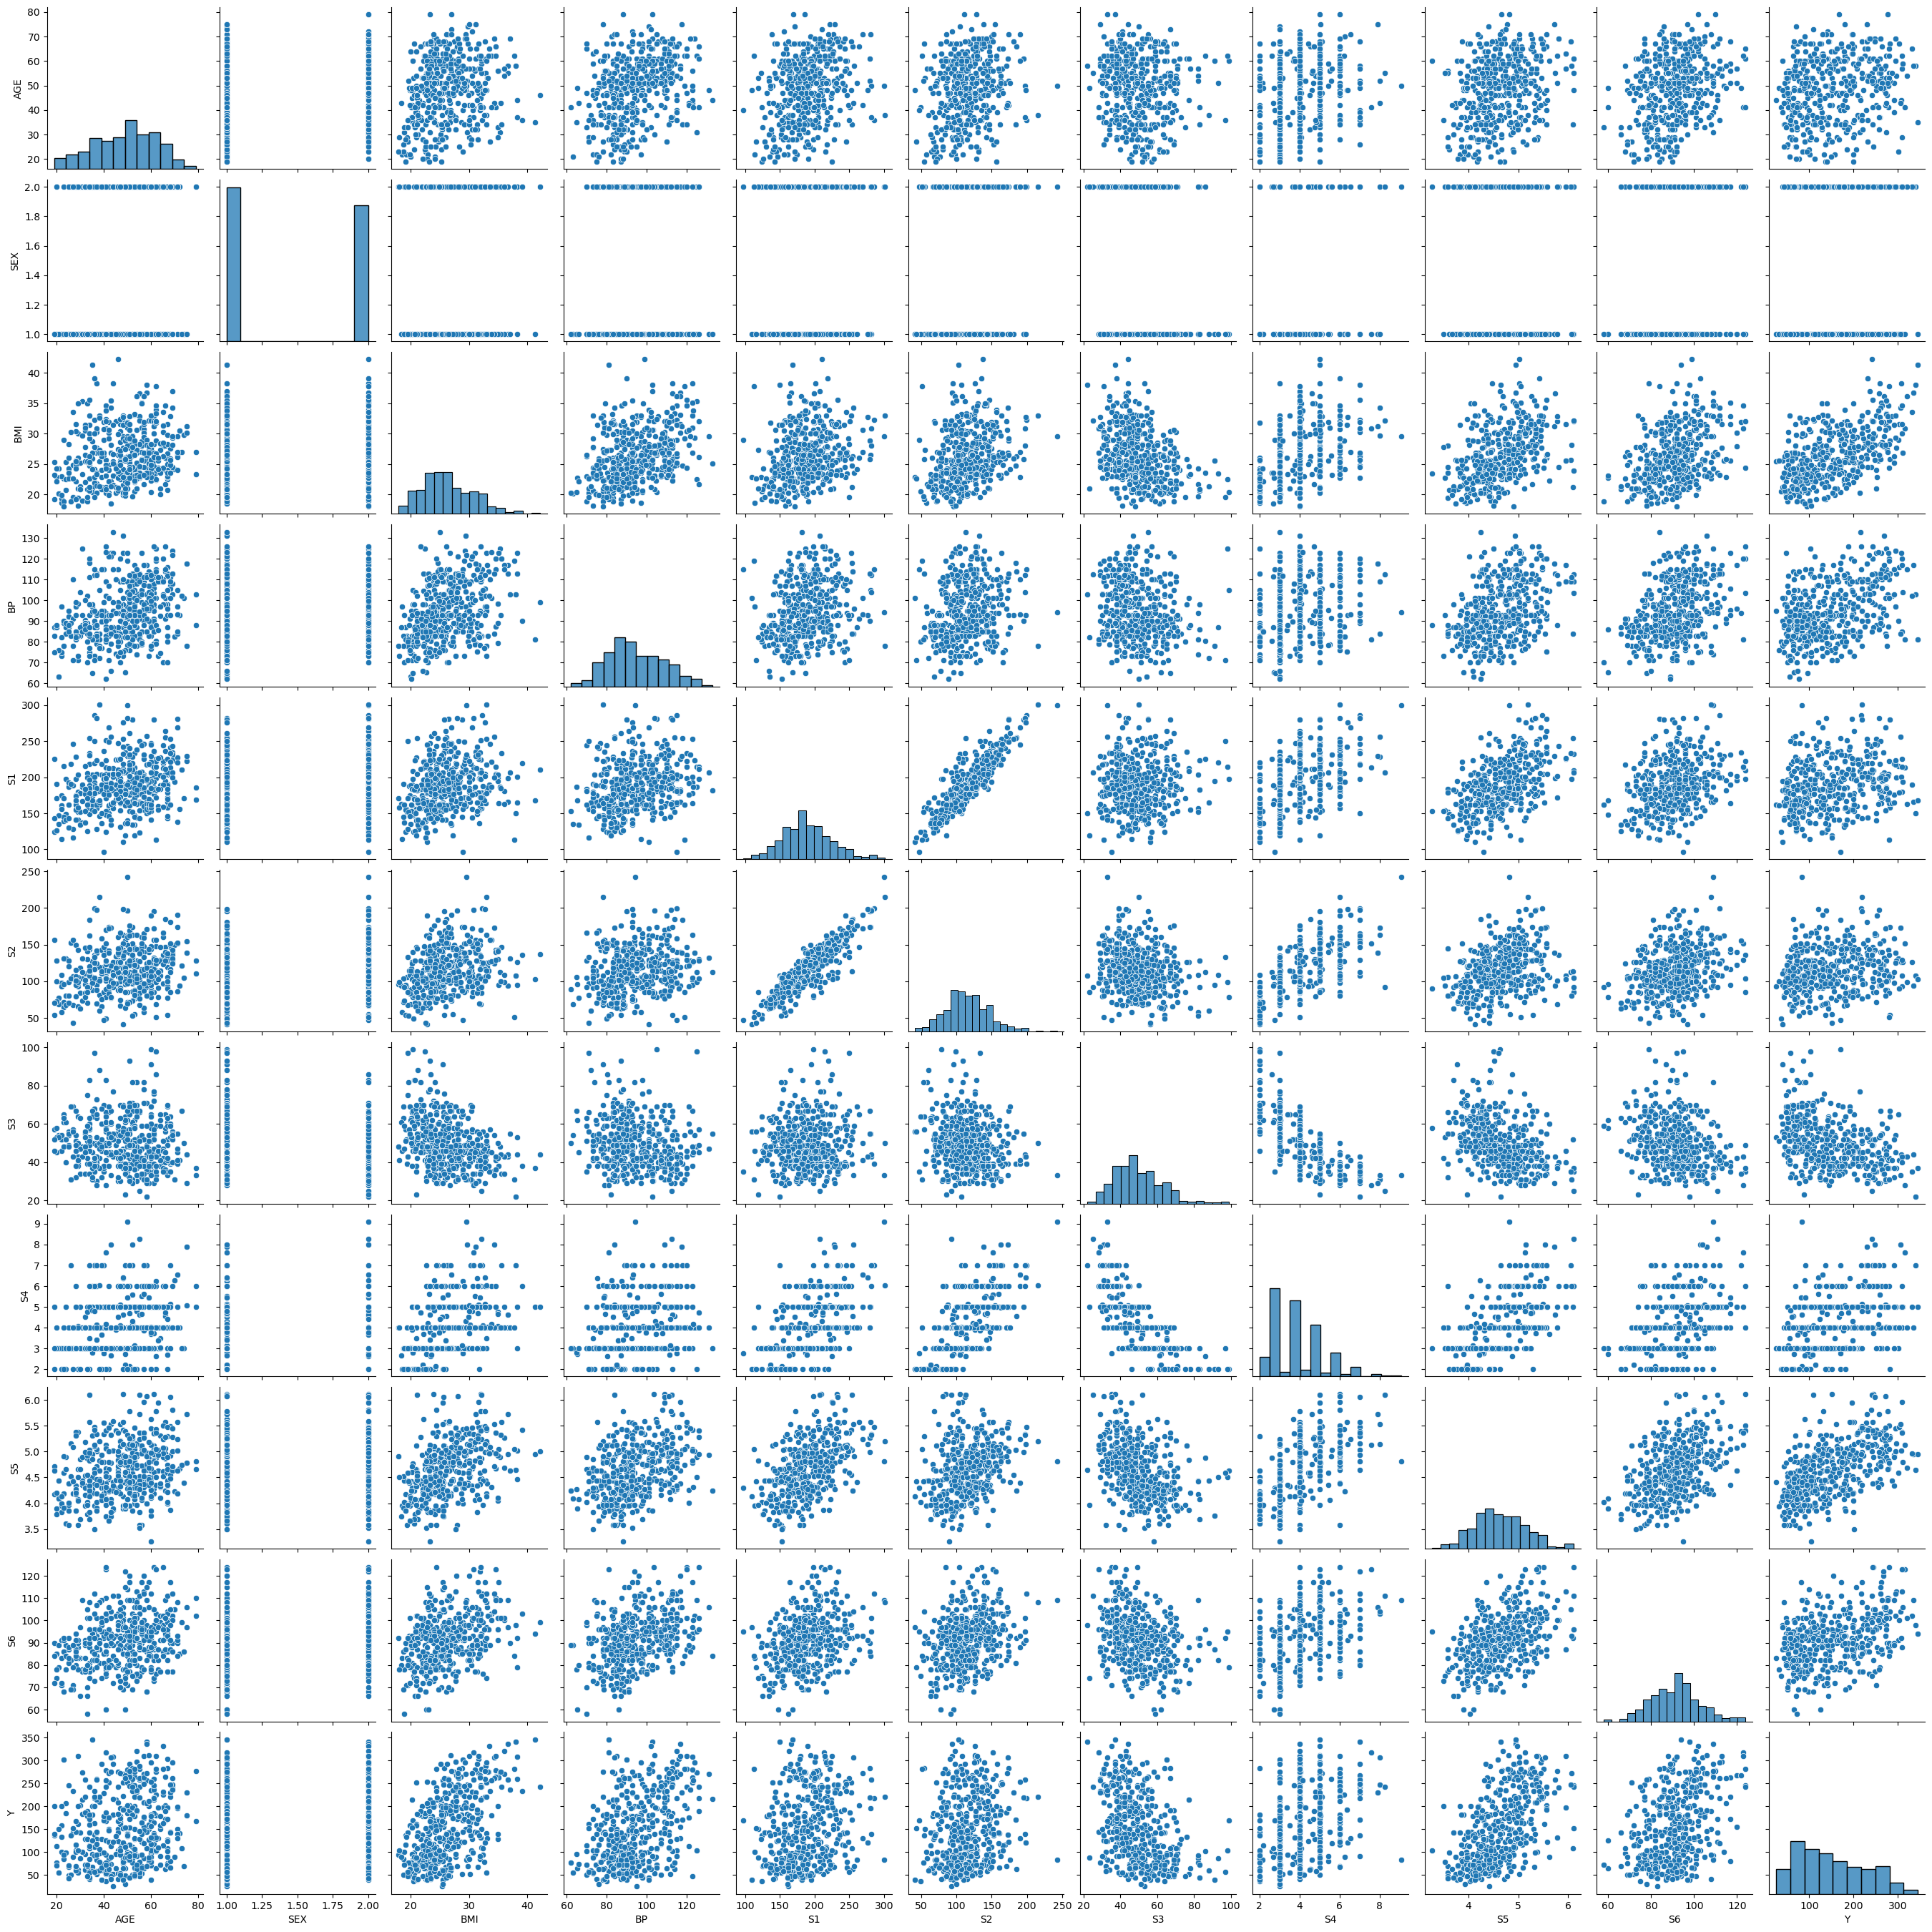

In [144]:
diabetes_db = pd.read_csv('diabetes.txt', sep='\t', header=0)
sn.pairplot(diabetes_db) 

In [145]:
diabetes_db.shape

(442, 11)

In [146]:
diabetes_db.head(10)

AGE  SEX   BMI     BP   S1     S2    S3    S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.00  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.00  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.00  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.00  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.00  4.2905  80  135
5   23    1  22.6   89.0  139   64.8  61.0  2.00  4.1897  68   97
6   36    2  22.0   90.0  160   99.6  50.0  3.00  3.9512  82  138
7   66    2  26.2  114.0  255  185.0  56.0  4.55  4.2485  92   63
8   60    2  32.1   83.0  179  119.4  42.0  4.00  4.4773  94  110
9   29    1  30.0   85.0  180   93.4  43.0  4.00  5.3845  88  310

We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [147]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'], # X
    diabetes_db['Y'], # y
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)

print(x_train.shape)

torch.Size([353, 10])


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [148]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here
  return (x-mu)/sigma

###your code here 
# dim=0 => column-level operations

mu = torch.mean(x_train, dim=0)
sigma = torch.std(x_train, dim=0)

x_train = norm_set(x_train, mu, sigma)
x_test = norm_set(x_test, mu, sigma)

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [149]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    return torch.matmul(x, self.weight.T)
   

As we need to account for the bias, we add a column of ones to the `x_data`

In [150]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1) 

In [151]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [152]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(y_pred-y_true))

In [153]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29711.3223)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [154]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  # calculate the partial derivative of the loss function with respect to w
  dEdw = -2/N * torch.sum(torch.matmul(y_pred.T - y.T, X), dim=0)
  # calculate the new values the weights
  weight += lr * dEdw
  model.weight = nn.Parameter(weight, requires_grad=False)

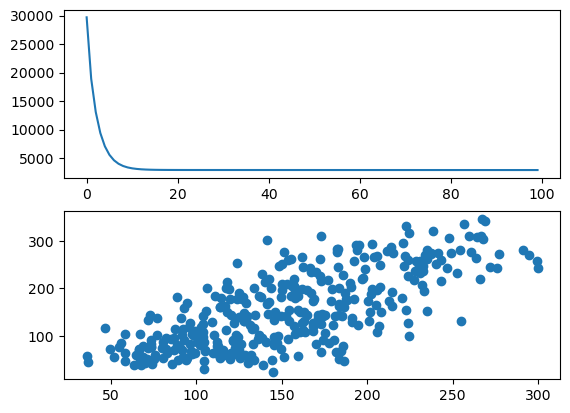

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [155]:
# training

cost_lst = list()
model = LinearRegression(x_train.shape[1])
wts = []
alpha = .1
for it in range(100):
    prediction = model(x_train)
    cost = mean_squared_error(y_train, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x_train, y_train, prediction, alpha)
    
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="red">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [156]:
x1 = torch.tensor([25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68]).reshape(1, -1)
x2 = torch.tensor([50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]).reshape(1, -1)

x1 = norm_set(x1, mu, sigma)
x2 = norm_set(x2, mu, sigma)
x1 = torch.cat([x1, torch.ones(x1.shape[0], 1)], dim=1)
x2 = torch.cat([x2, torch.ones(x2.shape[0], 1)], dim=1)

print(f"Blood sugar level Example 1: {model(x1)[0][0]}")
print(f"Blood sugar level Example 2: {model(x2)[0][0]}")

Blood sugar level Example 1: 43.52943420410156
Blood sugar level Example 2: 232.23094177246094


#### Female tend to have lower blood sugar levels because of the -ve wt. levels
#### BMI seems to be positively corelated to blood sugar levels. 
#### However the net effect of the other weights seems causing the blood sugar levels to change drastically.

Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [157]:
prediction = model(x_test)
mean_squared_error(y_test, prediction)

tensor(2885.6189)

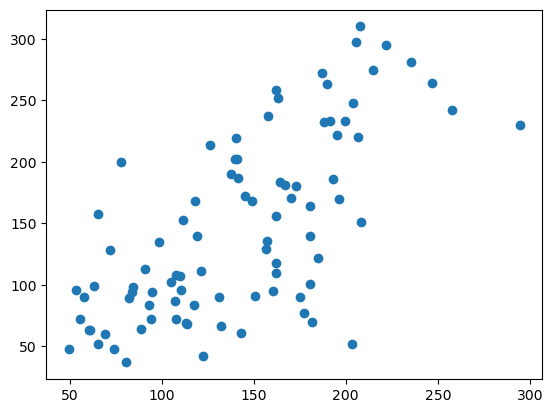

In [158]:
### your code here
plt.scatter(prediction, y_test)
plt.show()

#### The sparsity between the y_test and predicted values indicate the model has underfit the data.

<font color="red">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

Training cost 3066.773681640625
learning rate: 0.0125 test cost:3114.945556640625
Training cost 2898.609619140625
learning rate: 0.025 test cost:2890.0009765625
Training cost 2894.800048828125
learning rate: 0.05 test cost:2884.92236328125
Training cost 2888.496826171875
learning rate: 0.125 test cost:2885.8720703125
Training cost 2907.636962890625
learning rate: 0.25 test cost:2907.63525390625
Training cost 10136.5478515625
learning rate: 0.3 test cost:8.319514378800598e+30
Training cost 15319.40234375
learning rate: 0.45 test cost:nan
Training cost 19150.126953125
learning rate: 0.5 test cost:nan
Training cost 2890.406494140625
learning rate: 0.1 test cost:2885.618896484375
Training cost 3356.777587890625
learning rate: 0.01 test cost:3431.069580078125
Training cost 20040.583984375
learning rate: 0.001 test cost:18534.30859375
Training cost 28468.08203125
learning rate: 0.0001 test cost:25530.2265625
Training cost 29583.326171875
learning rate: 1e-05 test cost:26443.8125
Training cos

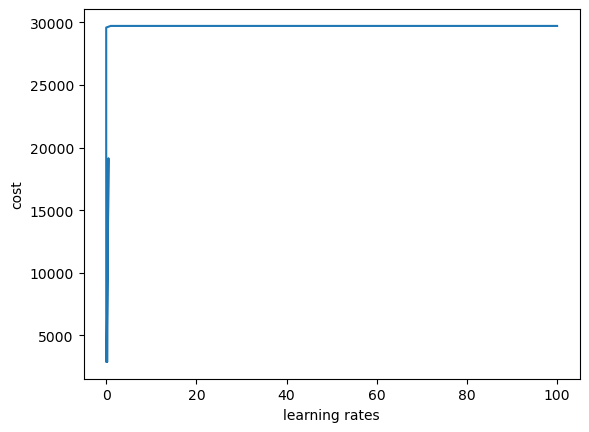

In [159]:
### your code here
learning_rates = [0.0125, 0.025, 0.05, 0.125, 0.25, 0.3, 0.45, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 1, 10, 100]

def training_function(x_test, y_test, alpha):
    cost_lst = list()
    model = LinearRegression(x_train.shape[1])
    for _ in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(prediction, y_train)
        cost_lst.append(cost)
        gradient_descent_step(model, x_train, y_train, prediction, alpha)
    
    print(f"Training cost {min(cost_lst)}")
    test_pred= model(x_test)
    cost = mean_squared_error(test_pred, y_test)
    print(f"learning rate: {alpha} test cost:{cost}")
    return cost_lst

min_costs = []
for alpha in learning_rates:
    cost_lst = training_function(x_test, y_test, alpha)
    # print(f"lr: {alpha} min cost: {min(cost_lst)}\n")
    min_costs.append(min(cost_lst))

plt.plot(learning_rates, min_costs)
plt.xlabel("learning rates")
plt.ylabel("cost")
plt.show()



#### Achived lowest cost for learning rate - 0.05

#### Keeping the no. of iterations constant and increasing the learing rate the convergence of the the cost function is slower

#### Keeping the learing rate same as the original value and increasing the iteration we'll see a sharp convergence in the value of the cost function

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting. 

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the higher order polynomials

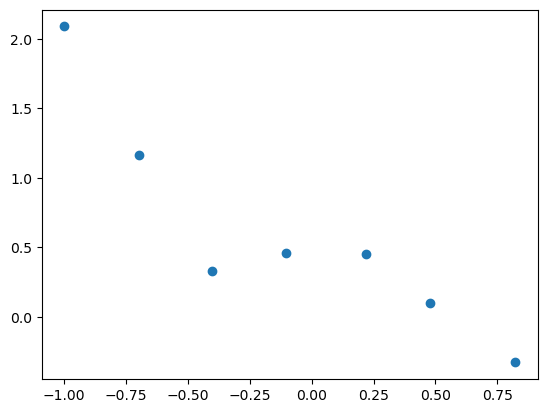

In [160]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In [161]:
degree = 5
phi = torch.tensor(list(map(lambda x: [x**i for i in range(degree+1)], x)))
phi.shape

torch.Size([7, 6])

**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [162]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  M = y_true.shape[0]
  return 1/(2*M) * ((torch.sum(torch.square(y_pred - y_true))) + (lam * torch.sum(torch.square(theta[1:]))))

In [163]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  M = X.shape[0]

  # bias update
  weight[0][0] -= (lr/M) * torch.matmul(X[:, 0].reshape(1, -1), (y_pred-y))[0][0]
  
  # weights update 
  weight[0][1:] = weight[0][1:] * (1-(lr*(lam/M))) - ((lr/M) * torch.matmul(X[:, 1:].T, (y_pred-y)).reshape(1, -1))

  model.weight = nn.Parameter(weight, requires_grad=False)

<font color="red"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

Weight: Parameter containing:
tensor([[ 0.3817, -0.2920,  0.0907, -0.7662,  0.1417, -0.4623]])
Minimum cost: 0.008262344636023045 and Lambda: 0.0001 Alpha: 1.0
Weight: Parameter containing:
tensor([[ 0.3817, -0.2917,  0.0907, -0.7671,  0.1416, -0.4618]])
Minimum cost: 0.008259697817265987 and Lambda: 0.0001 Alpha: 1.005050539970398
Weight: Parameter containing:
tensor([[ 0.3817, -0.2913,  0.0908, -0.7681,  0.1414, -0.4613]])
Minimum cost: 0.0082570631057024 and Lambda: 0.0001 Alpha: 1.0101009607315063
Weight: Parameter containing:
tensor([[ 0.3817, -0.2909,  0.0909, -0.7691,  0.1413, -0.4608]])
Minimum cost: 0.00825443398207426 and Lambda: 0.0001 Alpha: 1.0151515007019043
Weight: Parameter containing:
tensor([[ 0.3817, -0.2906,  0.0909, -0.7700,  0.1411, -0.4603]])
Minimum cost: 0.008251817896962166 and Lambda: 0.0001 Alpha: 1.0202020406723022
Weight: Parameter containing:
tensor([[ 0.3817, -0.2902,  0.0910, -0.7710,  0.1410, -0.4598]])
Minimum cost: 0.008249202743172646 and Lambda: 0.

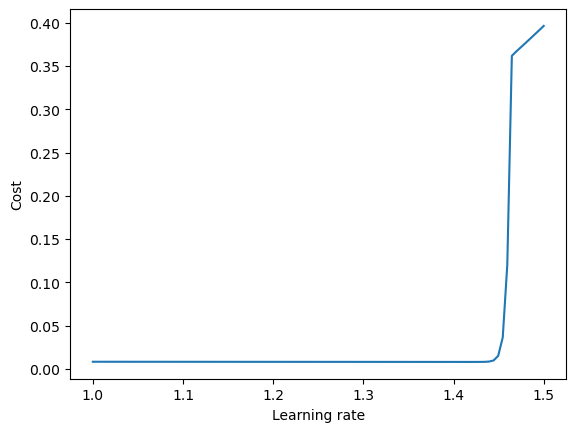

In [164]:
# testing for random alpha values

alphas = torch.linspace(1, 1.5, 100)
# torch.linspace(0.0001, 1.5, 10000)[:-1]

params = []

for alpha in alphas:

  cost_lst = list()
  model = LinearRegression(phi.shape[1])
  lam = 0.0001# select an appropriate lambda

  for it in range(100):
    prediction = model(phi)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, phi, y, prediction, alpha, lam)
  
  params.append(("weight", model.weight, "min cost", min(cost_lst), "lambda", lam, "alpha", alpha))
  print(f"Weight: {model.weight}")
  print('Minimum cost: {} and Lambda: {} Alpha: {}'.format(min(cost_lst), lam, alpha))

print(model.weight.shape)
plt.plot([x[7] for x in params], [x[3] for x in params])
plt.xlabel("Learning rate")
plt.ylabel("Cost")
plt.show()

In [165]:
min(params, key=lambda x: x[7])

('weight',
 Parameter containing:
 tensor([[ 0.3817, -0.2920,  0.0907, -0.7662,  0.1417, -0.4623]]),
 'min cost',
 tensor(0.0083),
 'lambda',
 0.0001,
 'alpha',
 tensor(1.))

Weight: Parameter containing:
tensor([[ 0.3817, -0.2920,  0.0907, -0.7662,  0.1417, -0.4623]])
Minimum cost: 0.008262344636023045 and Lambda: 0.00010001000191550702
Weight: Parameter containing:
tensor([[ 0.3817, -0.2922,  0.0907, -0.7660,  0.1418, -0.4623]])
Minimum cost: 0.008262808434665203 and Lambda: 0.00020002000383101404
Weight: Parameter containing:
tensor([[ 0.3816, -0.2923,  0.0907, -0.7658,  0.1418, -0.4623]])
Minimum cost: 0.00826327595859766 and Lambda: 0.00030002999119460583
Weight: Parameter containing:
tensor([[ 0.3816, -0.2924,  0.0907, -0.7656,  0.1418, -0.4623]])
Minimum cost: 0.008263746276497841 and Lambda: 0.0004000400076620281
Weight: Parameter containing:
tensor([[ 0.3816, -0.2925,  0.0907, -0.7654,  0.1419, -0.4623]])
Minimum cost: 0.008264211937785149 and Lambda: 0.0005000500241294503
Weight: Parameter containing:
tensor([[ 0.3816, -0.2926,  0.0907, -0.7652,  0.1419, -0.4623]])
Minimum cost: 0.008264679461717606 and Lambda: 0.0006000599823892117
Weight: Parame

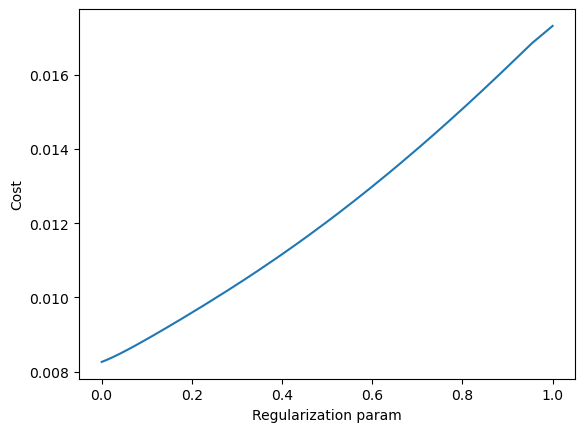

In [166]:
lambdas = torch.linspace(0, 1, 10000)[1:-1]

# lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0, 1, 2, 5, 10, 100]
params = []

for lam in lambdas:
  cost_lst = list()
  model = LinearRegression(phi.shape[1])
  alpha = 1 # select an appropriate alpha
  # lam = -0.1# select an appropriate lambda
  for it in range(100):
    prediction = model(phi)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, phi, y, prediction, alpha, lam)
  
  # plt.scatter(phi[:, 1], y, c='red', marker='x', label='groundtruth')
  # outputs = model(phi)
  # plt.plot(phi[:, 1], outputs, c='blue', marker='o', label=f'prediction for lambda={lam}')
  # plt.xlabel('y_true')
  # plt.ylabel('y_pred')
  # plt.legend()
  # plt.show()

  params.append(("weight", model.weight, "min cost", min(cost_lst), "lambda", lam))
  print(f"Weight: {model.weight}")
  print('Minimum cost: {} and Lambda: {}'.format(min(cost_lst), lam))


plt.plot([x[5] for x in params], [x[3] for x in params])
plt.xlabel("Regularization param")
plt.ylabel("Cost")
plt.show()

In [167]:
min(params, key=lambda x: x[3])

('weight',
 Parameter containing:
 tensor([[ 0.3817, -0.2920,  0.0907, -0.7662,  0.1417, -0.4623]]),
 'min cost',
 tensor(0.0083),
 'lambda',
 tensor(0.0001))

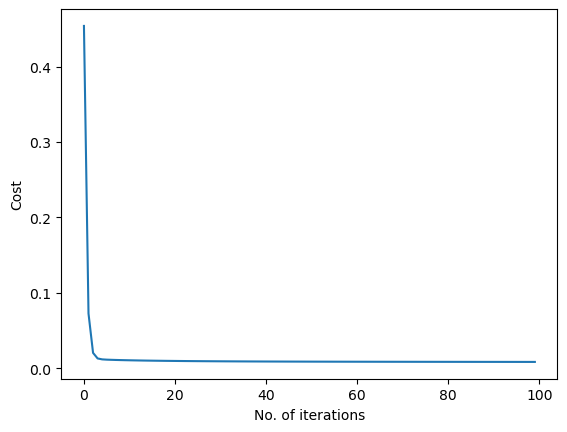

Weight: Parameter containing:
tensor([[ 0.3817, -0.2920,  0.0907, -0.7662,  0.1417, -0.4623]])
Minimum cost: 0.008262344636023045


In [168]:
cost_lst = list()
model = LinearRegression(phi.shape[1])
alpha = 1 # select an appropriate alpha
lam = 0.0001# select an appropriate lambda
for it in range(100):
    prediction = model(phi)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, phi, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.show()
params.append(("weight", model.weight, "min cost", min(cost_lst), "lambda", lam))
print(f"Weight: {model.weight}")
print('Minimum cost: {}'.format(min(cost_lst)))

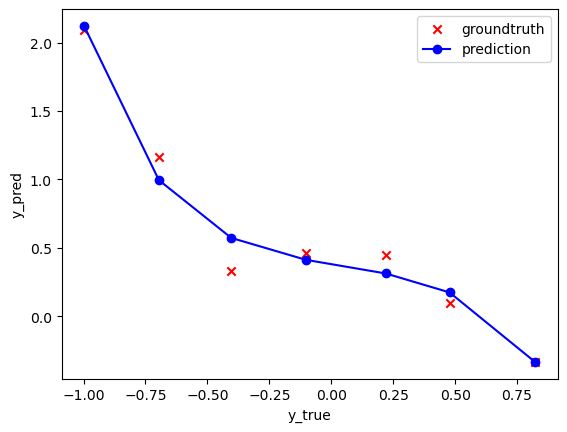

In [169]:
plt.scatter(phi[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(phi)
plt.plot(phi[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend()
plt.show()